#### Import required libraries

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import json
import hourglass 
import preprocessor
import utils

#### Visualize charts and annotations

In [2]:
# File paths to load JSON files
train_file = 'DeepRuleDataset/bardata(1031)/bar/annotations/processed/train_annotations_processed.json'
val_file = 'DeepRuleDataset/bardata(1031)/bar/annotations/processed/val_annotations_processed.json'

# Load processed annotations files
with open(train_file) as f:
        train_annotations = json.load(f)
with open(val_file) as f:
        val_annotations = json.load(f)

In [3]:
train_images = train_annotations['images']
train_annotations = train_annotations['annotations']
val_images = val_annotations['images']
val_annotations = val_annotations['annotations']

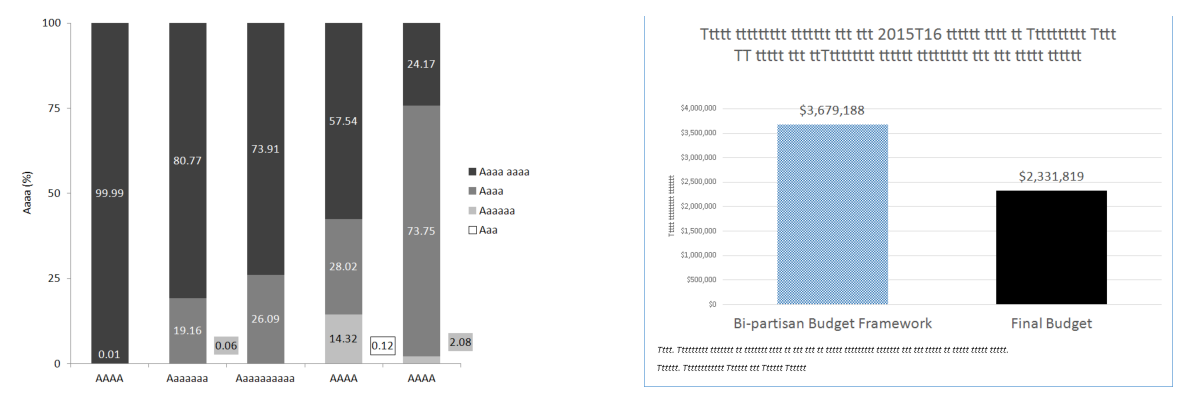

In [157]:
# Display images and annotations from training and validation data
TRAIN_PATH_BAR = 'DeepRuleDataset/bardata(1031)/bar/images/train2019'
VAL_PATH_BAR = 'DeepRuleDataset/bardata(1031)/bar/images/val2019'

index = 0
file_name = train_images[index]['file_name']
train_path = os.path.join(TRAIN_PATH_BAR, file_name)
train_image = cv2.cvtColor(cv2.imread(train_path), cv2.COLOR_BGR2RGB)
index_ = 750
file_name = val_images[index_]['file_name']
val_path = os.path.join(VAL_PATH_BAR, file_name)
val_image = cv2.cvtColor(cv2.imread(val_path), cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(train_image)
axs[1].imshow(val_image)
axs[0].axis('off')
axs[1].axis('off')
plt.show()

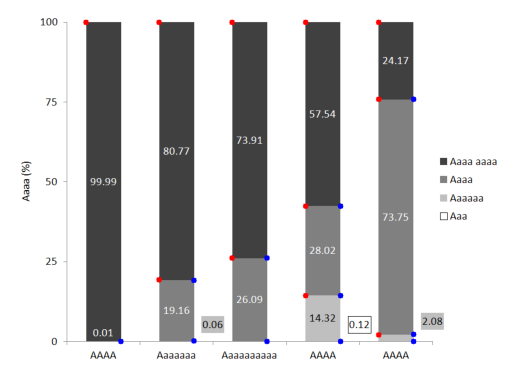

In [158]:
annotation = list(map(lambda x: x['bbox'], train_annotations[index]))
utils.annotshow(train_image, annotation)

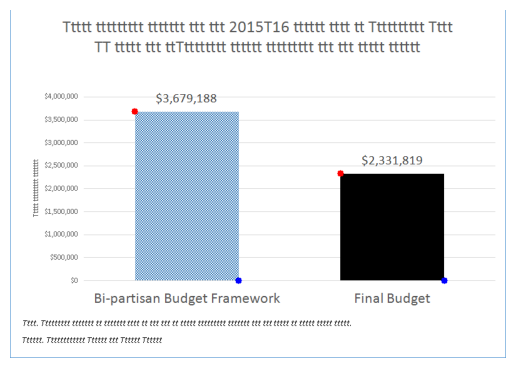

In [6]:
annotation_ = list(map(lambda x: x['bbox'], val_annotations[index_]))
utils.annotshow(val_image, annotation_)

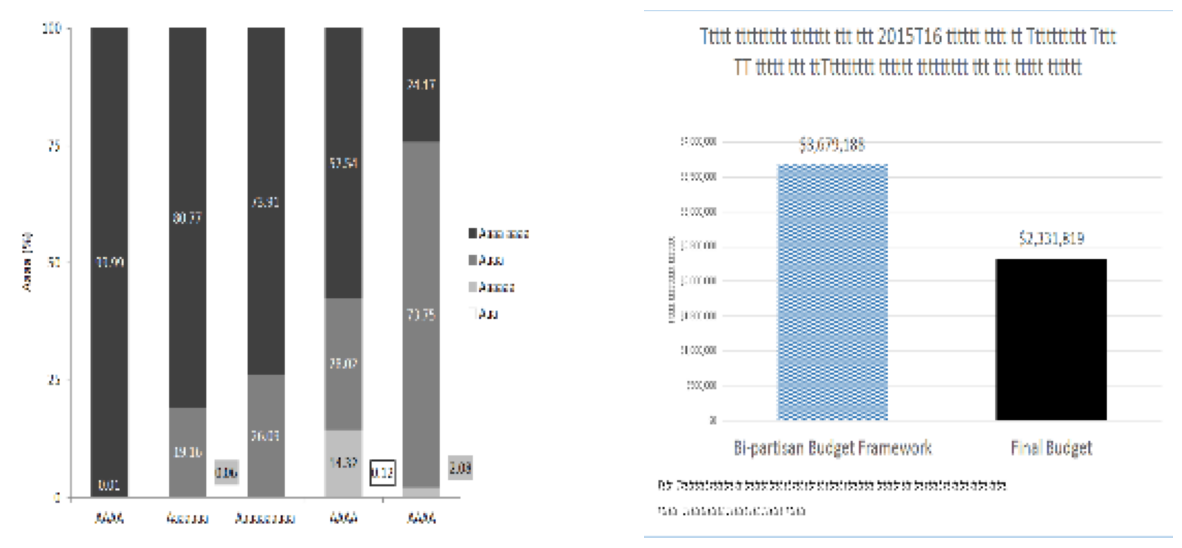

In [7]:
# Display resized images and scaled annotations
train_image_resized = cv2.resize(train_image, (256, 256))
val_image_resized = cv2.resize(val_image, (256, 256))
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(train_image_resized)
axs[1].imshow(val_image_resized)
axs[0].axis('off')
axs[1].axis('off')
plt.show()

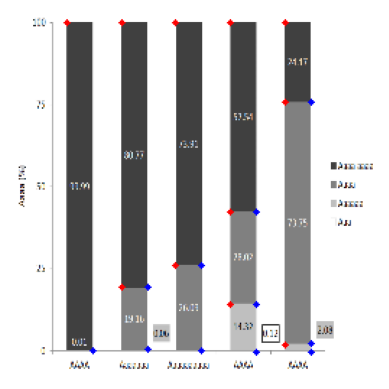

In [8]:
train_image_shape = (train_images[index]['width'], train_images[index]['height'])
OUTPUT_SHAPE = (256, 256)
scaled_train_annotation = preprocessor.scale(train_annotations[index], train_image_shape, OUTPUT_SHAPE)
utils.annotshow(train_image_resized, list(map(lambda x: x['bbox'], scaled_train_annotation)), radius=2)

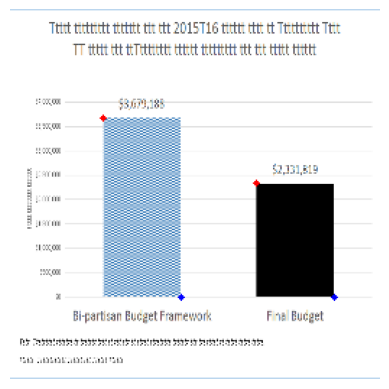

In [9]:
val_image_shape = (val_images[index_]['width'], val_images[index_]['height'])
scaled_val_annotation = preprocessor.scale(val_annotations[index_], val_image_shape, OUTPUT_SHAPE)
utils.annotshow(val_image_resized, list(map(lambda x: x['bbox'], scaled_val_annotation)), radius=2)

#### Preprocessing

In [10]:
TRAIN_HEATMAPS_PATH = 'DeepRuleDataset/bardata(1031)/bar/heatmaps/train'
BATCH_SIZE = 8

In [26]:
heatmaps = sorted(glob(pathname='*.npz', root_dir=TRAIN_HEATMAPS_PATH))
train_heatmaps = [os.path.join(TRAIN_HEATMAPS_PATH, item) for item in heatmaps]
gen = preprocessor.generator(train_images, train_heatmaps, batch_size=BATCH_SIZE, output_shape=OUTPUT_SHAPE, file_path=TRAIN_PATH_BAR)

#### Preprocessing Validation Data

In [12]:
VAL_HEATMAPS_PATH = 'DeepRuleDataset/bardata(1031)/bar/heatmaps/val'

In [13]:
val_heatmaps = sorted(glob(pathname='*.npz', root_dir=VAL_HEATMAPS_PATH))
val_heatmaps = [os.path.join(VAL_HEATMAPS_PATH, item) for item in val_heatmaps]
val_gen = preprocessor.generator(val_images, val_heatmaps, batch_size=BATCH_SIZE, output_shape=OUTPUT_SHAPE, file_path=VAL_PATH_BAR)

#### Training

In [18]:
# Define custom loss function

@tf.keras.utils.register_keras_serializable()
def custom_loss(y_true, y_pred):
    loss = tf.math.reduce_mean(tf.math.square(y_pred - y_true))
    return loss

In [15]:
num_samples = len(train_images)
steps_per_epoch = num_samples // BATCH_SIZE
print(f'steps_per_epoch: {steps_per_epoch}')

steps_per_epoch: 19758


In [16]:
num_val_samples = len(val_images)
validation_steps = num_val_samples // BATCH_SIZE
print(f'validation_steps: {validation_steps}')

validation_steps: 764


In [20]:
# When passing an infinitely repeating dataset (just like ourselves), we must specify the steps_per_epoch and validation_steps arguments

from hourglass import StackedHourglassNetwork
from keras.metrics import RootMeanSquaredError
from keras.callbacks import ModelCheckpoint

stacked_hourglass = StackedHourglassNetwork(input_shape=(256, 256, 3), num_stack=1)
stacked_hourglass.compile(optimizer='sgd', loss=custom_loss, metrics=[RootMeanSquaredError()])
checkpoint_cb = ModelCheckpoint('SavedModels/key-point-detector.keras')
history = stacked_hourglass.fit(x=gen, validation_data=val_gen, epochs=10, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, callbacks=[checkpoint_cb])

Epoch 1/3


KeyboardInterrupt: 

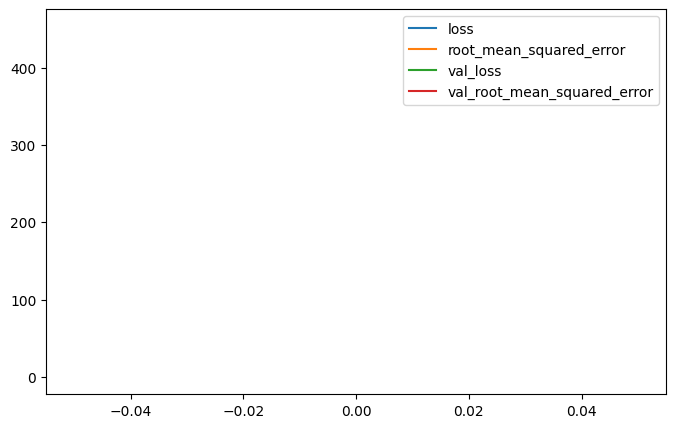

In [25]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [16]:
stacked_hourglass.summary()

Model: "stacked_hourglass"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ re_lu[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      4,160 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      8,320 │ re_lu[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 256, 256,  │      8,320 │ re_lu_3[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ conv2d_1[0][0],   │
│                     │ 128)              │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ add[0][0]         │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat

 Total params: 4,301,700 (16.41 MB)

 Trainable params: 4,280,962 (16.33 MB)

 Non-trainable params: 20,736 (81.00 KB)

 Optimizer params: 2 (12.00 B)

#### Inference

In [318]:
from tensorflow.keras.models import load_model
stacked_hourglass = load_model('SavedModels/key-point-detector-2.keras')

In [319]:
paths = [os.path.join(TRAIN_PATH_BAR, image['file_name']) for image in train_images[0:16]]
X = np.array([cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB), OUTPUT_SHAPE) for path in paths])

In [320]:
predictions = stacked_hourglass.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step


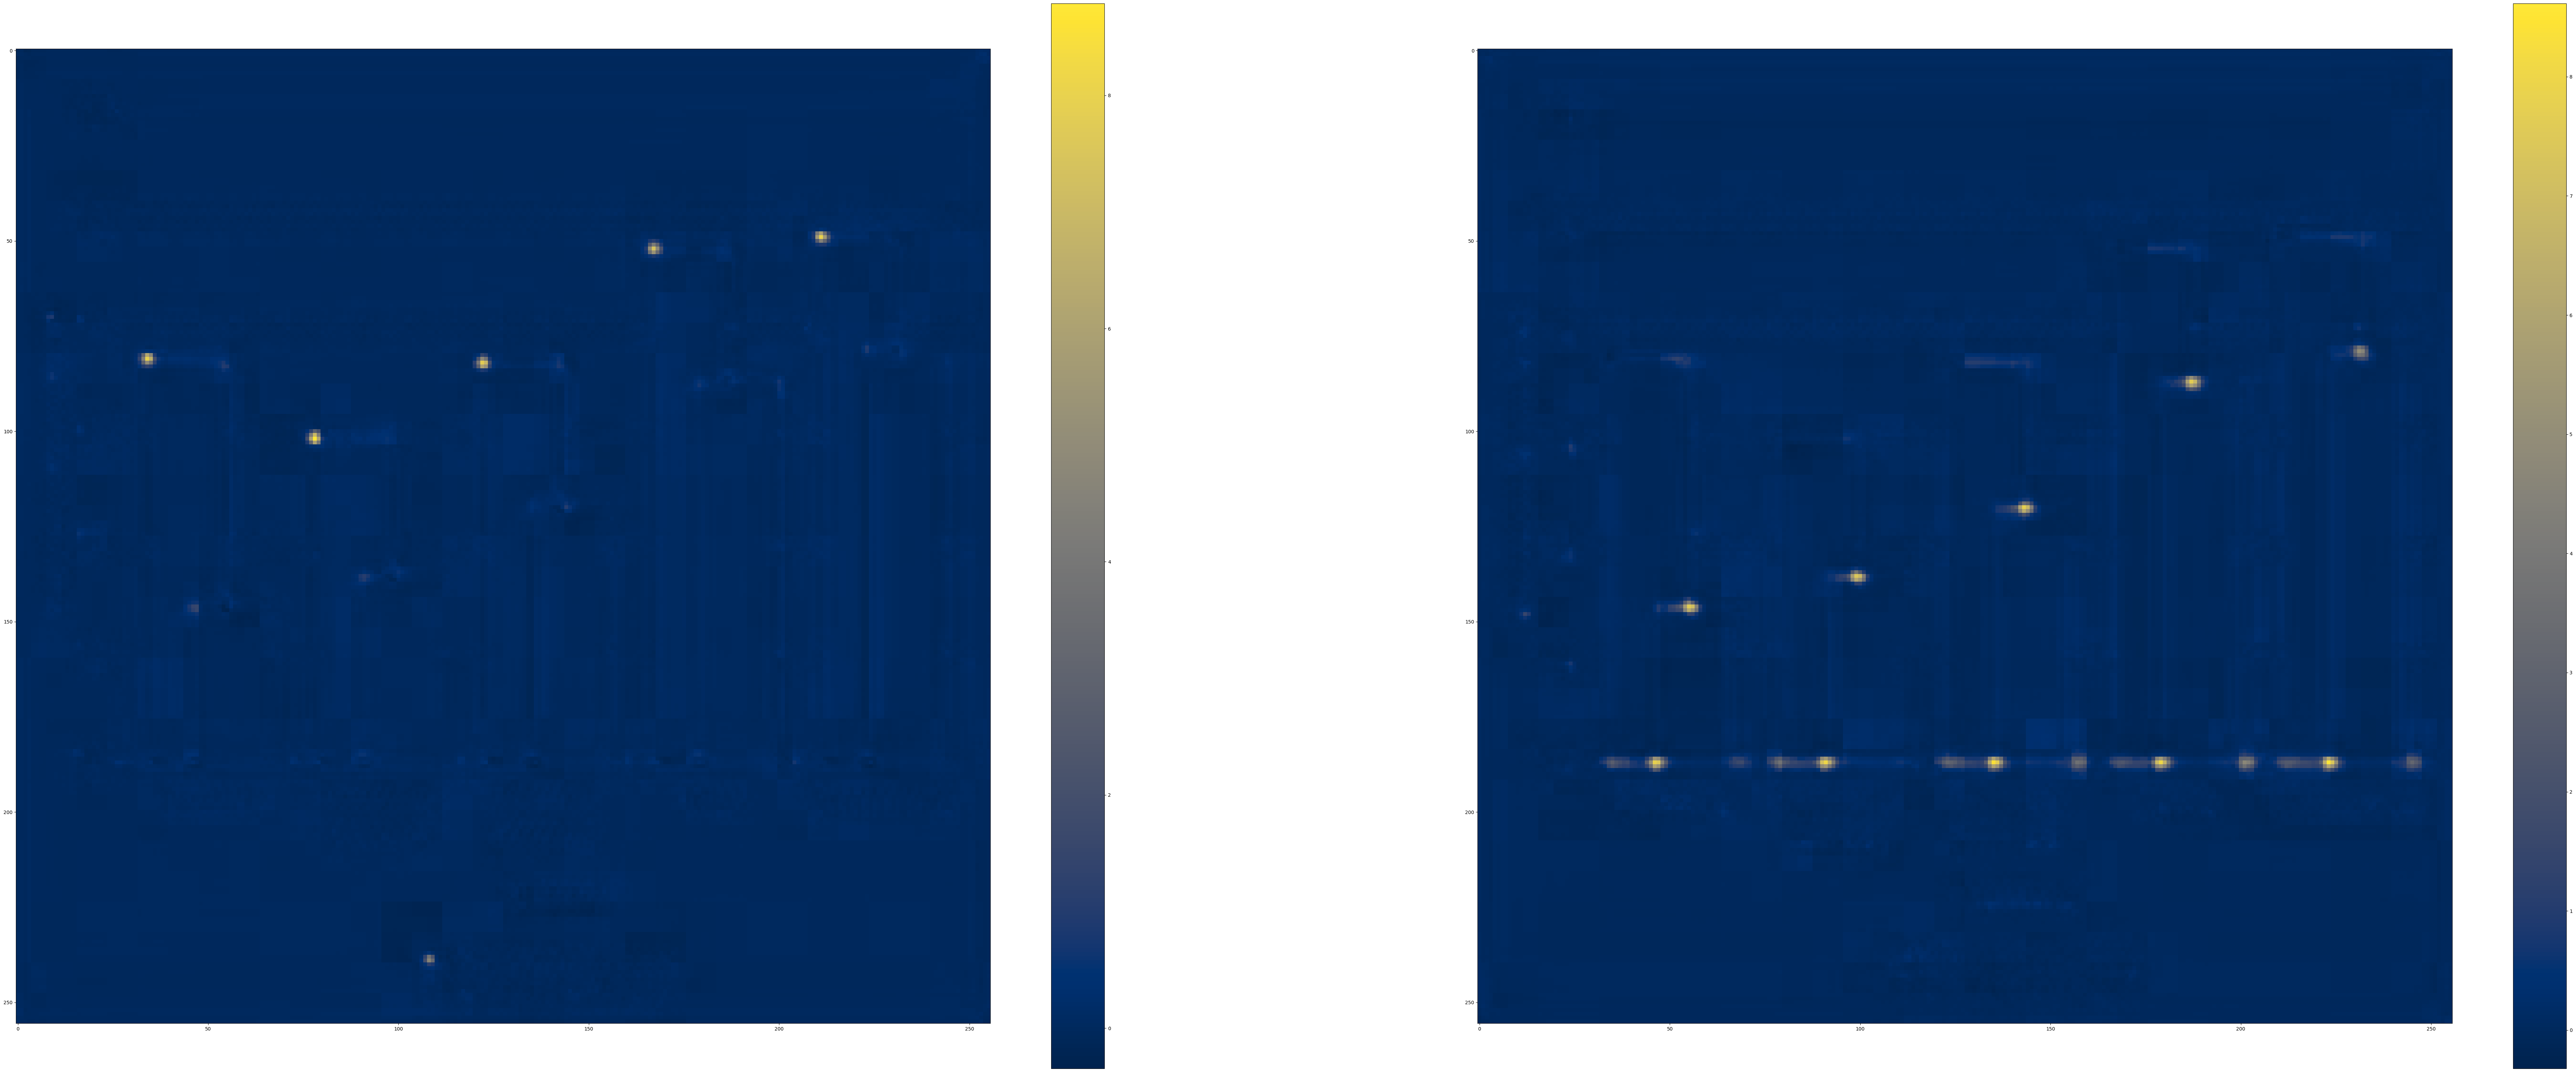

In [342]:
index = 4
predicted_heatmap = predictions[0][index]
fig, axes = plt.subplots(1, 2, figsize=(100, 100))
img1 = axes[0].imshow(tf.transpose(predicted_heatmap, perm=[2, 0, 1])[0], cmap='cividis',interpolation='nearest')
img2 = axes[1].imshow(tf.transpose(predicted_heatmap, perm=[2, 0, 1])[1], cmap='cividis',interpolation='nearest')
fig.colorbar(img1, ax=axes[0], shrink=0.4)
fig.colorbar(img2, ax=axes[1], shrink=0.4)
plt.show()

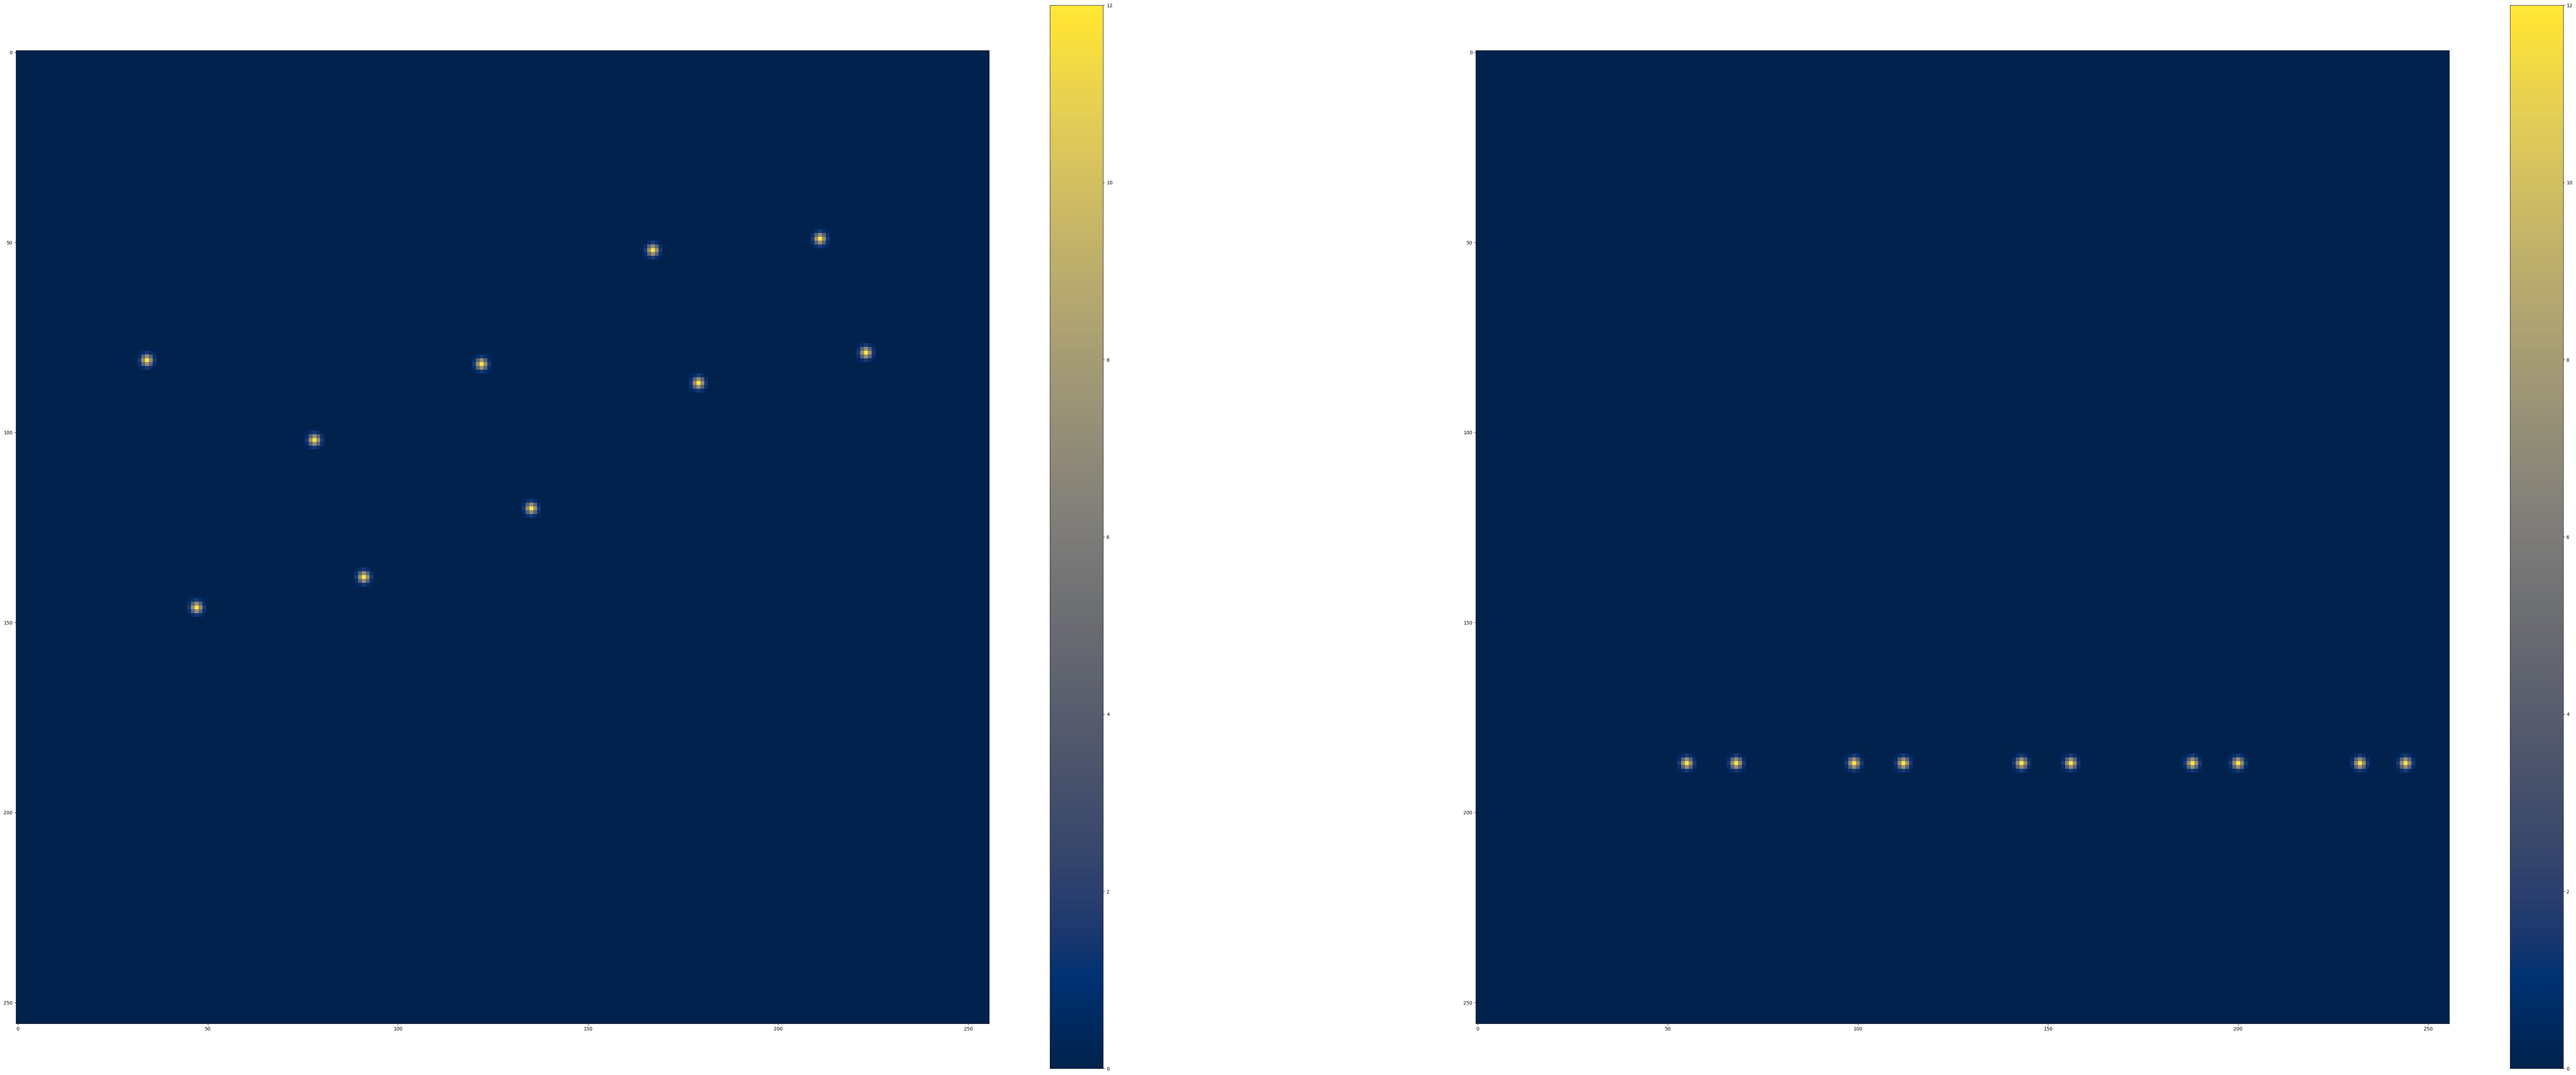

In [343]:
# load two batches of train heatmaps
heatmaps = sorted(glob(pathname='*.npz', root_dir=TRAIN_HEATMAPS_PATH))[0:2]
train_heatmaps = [os.path.join(TRAIN_HEATMAPS_PATH, item) for item in heatmaps]
train_heatmaps = np.concatenate([np.load(heatmap)['batch'] for heatmap in train_heatmaps], axis=0)
heatmap = train_heatmaps[index]
fig, axes = plt.subplots(1, 2, figsize=(100, 100))
img1 = axes[0].imshow(tf.transpose(heatmap, perm=[2, 0, 1])[0], cmap='cividis',interpolation='nearest')
img2 = axes[1].imshow(tf.transpose(heatmap, perm=[2, 0, 1])[1], cmap='cividis',interpolation='nearest')
fig.colorbar(img1, ax=axes[0], shrink=0.4)
fig.colorbar(img2, ax=axes[1], shrink=0.4)
plt.show()

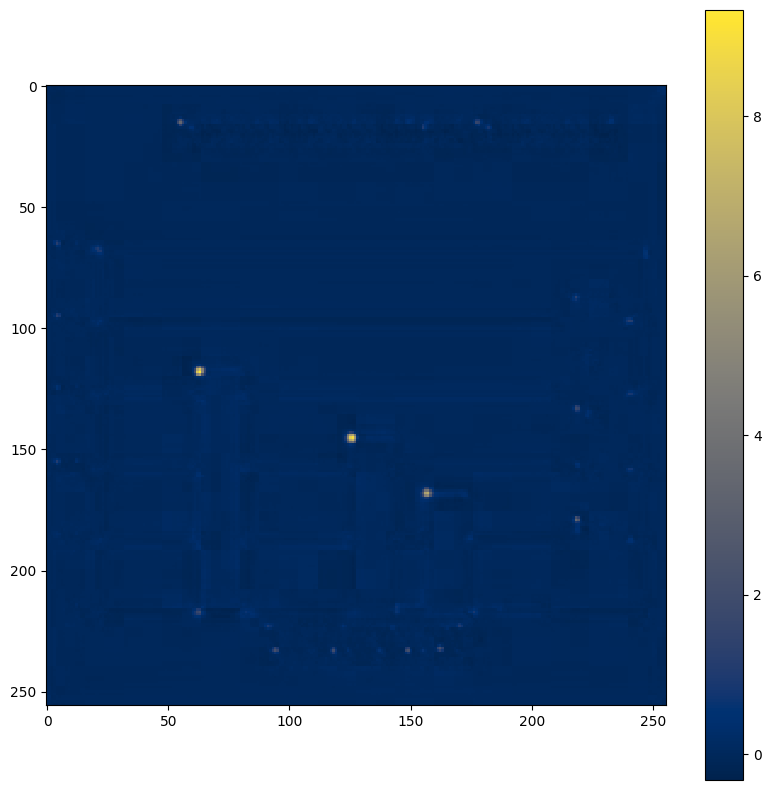

In [329]:
predicted_heatmap = predictions[0][index]
plt.figure(figsize=(10, 10))
plt.imshow(tf.transpose(predicted_heatmap, perm=[2, 0, 1])[0], cmap='cividis',interpolation='nearest')
plt.colorbar()
plt.show()

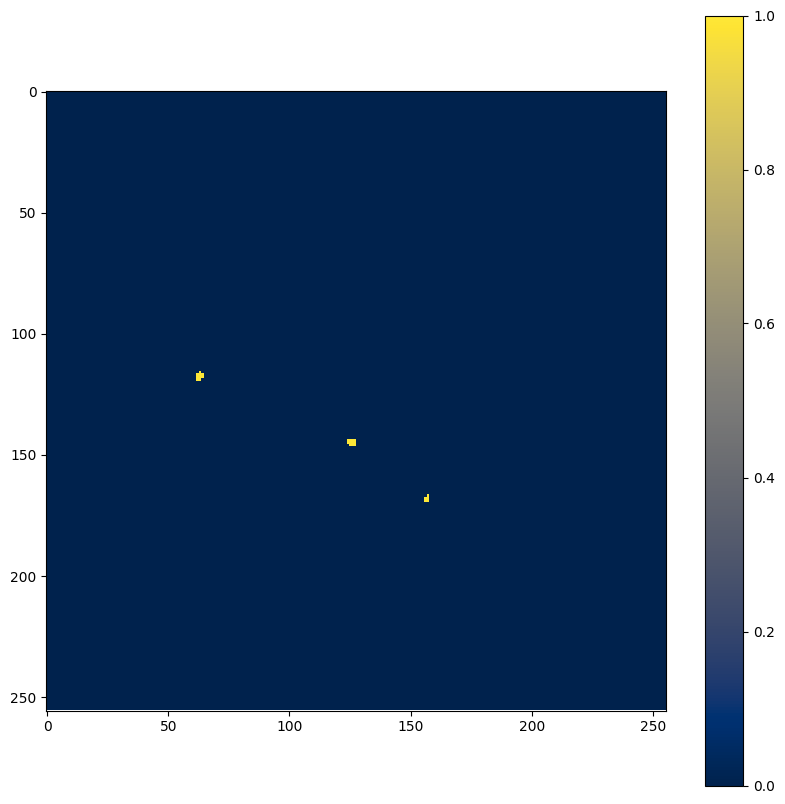

In [330]:
threshold = 4
heatmap_thresholded = (predicted_heatmap > threshold)
plt.figure(figsize=(10, 10))
plt.imshow(tf.transpose(heatmap_thresholded, perm=[2, 0, 1])[0], cmap='cividis',interpolation='nearest')
plt.colorbar()
plt.show()